In [1]:
from dataclasses import dataclass
import numpy as np
from typing import Tuple, Dict, Callable
import matplotlib.pyplot as plt

from scipy.optimize import root
import random as rd
from itertools import product
import pandas as pd
#import statsmodels.api as sm
import scipy.optimize as opt
import scipy.interpolate as interp
from scipy.stats import norm
from numba import jit, njit, int32, float64
import quantecon as qe
from numba.typed import Dict,List
import numba as nb

In [2]:
seed = 123
rd.seed(seed)

In [3]:
n_to_use = 1000

In [4]:
f_x_y = pd.read_csv('E:\\panel_fr_res\\calibration\\f_x_y_03_06.csv').dropna()
list_y_table = pd.read_csv('E:\\panel_fr_res\\calibration\\list_y.csv').dropna()
if n_to_use == None:
    n_to_use = len(list_y_table)
else:
    list_y_table = list_y_table.sample(n_to_use)
list_x_table = pd.read_csv('E:\\panel_fr_res\\calibration\\list_x.csv').dropna().sample(n_to_use)


In [5]:
pivot_m = f_x_y.pivot(index="x", columns="y", values="z_hat_private")

# 3) Extract sorted grids and matrix
x_grid = pivot_m.index.values.astype(float)   # shape (nx,)
y_grid = pivot_m.columns.values.astype(float) # shape (ny,)
z_m_grid  = pivot_m.values.astype(float)         # shape (nx, ny)

In [6]:
f_x_y

,x,y,z_hat_private,z_hat_public
0,-6.727422,-3.032924,-6.269323,-3.841904
1,-6.594505,-3.032924,-6.193562,-3.815670
2,-6.461587,-3.032924,-6.117899,-3.789436
3,-6.328670,-3.032924,-6.042430,-3.763203
4,-6.195752,-3.032924,-5.967252,-3.736970
...,...,...,...,...
9995,5.899734,6.439021,7.231819,8.695859
9996,6.032651,6.439021,7.287937,8.782572
9997,6.165569,6.439021,7.344406,8.869295
9998,6.298486,6.439021,7.401108,8.956022


In [7]:
pivot_g = f_x_y.pivot(index="x", columns="y", values="z_hat_public")

# 3) Extract sorted grids and matrix
z_g_grid  = pivot_g.values.astype(float)         # shape (nx, ny)

In [8]:
list_x = sorted(list(list_x_table[list_x_table['Period'] == "2003-2006"]['x']))

In [9]:
x_distrib =   (np.sort(list_x))
y_distrib_g = (np.sort(list_y_table[(list_y_table['public']==1 ) & (list_y_table['Period'] == "2003-2006" )]['y'].tolist()))
y_distrib_m = (np.sort(list_y_table[(list_y_table['public']==0 ) & (list_y_table['Period'] == "2003-2006" )]['y'].tolist()))



In [12]:
@njit

def _find_interval(val, grid):
    """
    Find i such that grid[i] <= val <= grid[i+1], clamped to edges.
    Assumes grid is sorted ascending.
    """
    if val <= grid[0]:
        return 0
    n = grid.shape[0]
    if val >= grid[n - 1]:
        return n - 2

    # linear search is OK for small grids; for larger, use np.searchsorted
    # i = np.searchsorted(grid, val) - 1
    # return max(0, min(i, n - 2))
    for i in range(n - 1):
        if grid[i] <= val <= grid[i + 1]:
            return i
    return n - 2

@njit
def _bilinear_interp(x, y, x_grid, y_grid, z_mat):
    i = _find_interval(x, x_grid)
    j = _find_interval(y, y_grid)

    x1, x2 = x_grid[i],     x_grid[i + 1]
    y1, y2 = y_grid[j],     y_grid[j + 1]

    z11 = z_mat[i,     j]
    z21 = z_mat[i + 1, j]
    z12 = z_mat[i,     j + 1]
    z22 = z_mat[i + 1, j + 1]

    tx = 0.0 if x2 == x1 else (x - x1) / (x2 - x1)
    ty = 0.0 if y2 == y1 else (y - y1) / (y2 - y1)

    z1 = z11 * (1 - tx) + z21 * tx
    z2 = z12 * (1 - tx) + z22 * tx
    return z1 * (1 - ty) + z2 * ty

@njit
def predict_z(x, y, x_grid=x_grid, y_grid=y_grid, z_mat = z_g_grid):
    """
    Predict z for given (x, y) using bilinear interpolation on the grid.
    x, y can be scalars or 1D numpy arrays of the same length.
    """
    return _bilinear_interp(x, y, x_grid, y_grid, z_mat)

In [13]:
########### Parameters

beta = 0.992
delta = 0.01
alpha_m = 0.5
phi = 0.5
gamma = 0.5
nx = len(list_x)
ny = len(y_distrib_g)+len(y_distrib_m)
nyg = len(y_distrib_g)
nym = len(y_distrib_m)
lambda_g = nyg/ny
lambda_m = 1- lambda_g

scaling_matching = 0.7

In [14]:
@njit
def m_u_v(u,v):
    return(scaling_matching  *( u**(0.5)) * (v **0.5))
#@njit
#def d_x_y(x,y):
#    return(1)
@njit
def f(x,y,l):
    if l == 'm':
        return(predict_z(x, y, x_grid, y_grid,z_m_grid))
    if l == 'g':
        return(predict_z(x, y, x_grid, y_grid,z_g_grid))


In [15]:
import numpy as np
from numba import types
from numba.experimental import jitclass

# ---- jitclass field spec (all typed) ----
spec = [
    ('x_val',     types.float64[:]),
    ('y_g_val',   types.float64[:]),
    ('y_m_val',   types.float64[:]),
    ('V_e_x_y', types.float64[:, :]),
    ('V_u',       types.float64[:]),
    ('V_p_x_y', types.float64[:, :]),
    ('V_v_y_m',   types.float64[:]),
    ('V_v_y_g',   types.float64[:]),
    ('u',         types.float64),
    ('V',         types.float64),
    ('e',         types.float64),
    ('matches',   types.int64[:, :]),
    ('states_w',  types.int64[:]),
    ('states_f',  types.int64[:]),
    ('d_y',       types.float64[:]),
    ('d_x',       types.float64[:]),
    ('d_xy',      types.float64[:, :]),
    #('seq',       types.ListType(types.ListType(types.float64[:])) ) ,
    ('n_params',  types.int64)
]

n_params =len(spec)
@jitclass(spec)
class ModelCurrent:
    def __init__(self, x_distrib, y_distrib_g, y_distrib_m, matches_distrib = None):
        # Ensure contiguous float64 inputs

        # Unpack columns
        self.x_val = np.asarray(x_distrib, dtype=np.float64)
        self.y_g_val = np.asarray(y_distrib_g, dtype=np.float64)
        self.y_m_val = np.asarray(y_distrib_m, dtype=np.float64)
        nx  = len(x_distrib)
        nyg = len(y_distrib_g)
        nym = len(y_distrib_m)
        ny = nyg+nym

        
        # ---- Build Cartesian products via tile/repeat (Numba-friendly) ----
        # For "g"

        def cart2mat(a, b):
            na = len(a)
            nb = len(b)
            N  = na * nb
            M  = np.empty((na, nb), np.float64)
            idx = 0
            for i in range(na):
                ai = a[i]
                for j in range(nb):
                    bj = b[j]
                    M[i, j] = np.float64(ai) * np.float64(bj)
            return M

        y_all = np.empty(nyg + nym, dtype=np.float64)
        for i in range(nyg):
            y_all[i] = self.y_g_val[i]
        for j in range(nym):
            y_all[nyg + j] = self.y_m_val[j]
        self.V_e_x_y = cart2mat(self.x_val, y_all)
        self.V_p_x_y = cart2mat(self.x_val, y_all)
        ##model.V_u: [x_value, 0.5]
        self.V_u = np.full(nx, np.float64(0))

        ## V_v_y_*
        self.V_v_y_g = np.full(nyg, np.float64(0))
        self.V_v_y_m = np.full(nym, np.float64(0))

        ## Scalars
        self.u = np.float64(0)
        self.V = np.float64(0.2)
        self.e = np.float64(1)

        ## 
        initial_distrib = np.random.permutation(min(nx, ny))  # Permute up to the smallest length
        matches = np.zeros((nx, ny), dtype=np.int64)
        
        for x in range(len(initial_distrib)):
            matches[x, initial_distrib[x]] = 1        
        self.matches = matches
        self.states_w = np.full(nx,np.int64(1))
        self.states_f = np.full(nyg+nym, np.int64(1))
        #

        ## distribution of matches :
        if matches_distrib is not None:
            self.d_xy = matches_distrib
        else:
            self.d_xy = matches/np.sum(matches)
        ## d_y: 
        self.d_y = np.full(nyg + nym, np.float64(0))

        ## d_x: 
        self.d_x = np.full(nx, np.float64(0))

        ### sequence of updated differences of values:
   #     self.seq =  List.empty_list(types.ListType((types.float64[:])) )

        self.n_params = np.int64(n_params)

    #def append_seq_row(self, row):
    #    if row.shape[0] != 9:
    #        raise ValueError(1)   # Numba needs small ints; use codes not strings
    #    # Make a copy to avoid aliasing external buffer
    #    r = np.empty(9, np.float64)
    #    for i in range(9):
    #        r[i] = row[i]
    #    self.seq.append(r)


In [16]:
current_model = ModelCurrent(x_distrib,y_distrib_g,y_distrib_m, matches_distrib = None)

In [17]:
@njit
def w_x_y(x,y,l, model):
    if l == 'm':
        V_t = model.V_e_x_y[x,y]
        x_val = model.x_val[x]
        y_val = model.y_m_val[y-nyg]
        
        M_e = phi* m_u_v(model.u+ phi* model.e, model.V)/(model.u + phi * model.e)
    
        potential_jobs_g = [ model.V_e_x_y[x,y_prime] *model.d_y[y_prime]
                                         for y_prime in range(0, nyg) if model.V_e_x_y[x,y_prime] > V_t
                                        and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
        int_g = [model.d_y[y_prime]
                                         for y_prime in range(0, nyg) if model.V_e_x_y[x,y_prime] > V_t
                                        and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
        potential_jobs_m =[ model.V_e_x_y[x,nyg+y_prime] *model.d_y[y_prime]
                                         for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] >  V_t
                                        and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]
        int_m = [ model.d_y[y_prime]
                                         for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] > V_t
                                        and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]

        sum_potential_jobs = beta * (1 - delta) * M_e * (lambda_g  *( sum(potential_jobs_g) - sum(int_g)  * model.V_u[x] ) + lambda_m *( sum(potential_jobs_m) - sum(int_m)  * model.V_u[x] ) ) 
        w= (alpha_m - (1- alpha_m) * gamma) * f(x_val,y_val,'m') - alpha_m * (1-beta) *model.V_v_y_m[y-nyg] + ( 1 - alpha_m ) * (1 - beta) * model.V_u[x] - (1- alpha_m) * sum_potential_jobs
        return(w )
    if l == 'g':
        return(  0 )


In [115]:
@njit
def new_V_u_x(x,model):
    """
    Update value function for unemployed people at time t
    """
    M_u = m_u_v(model.u+ phi* model.e, model.V)/(model.u + phi * model.e)
    potential_jobs_g = [ model.V_e_x_y[x,y] *model.d_y[y]
                                     for y in range(0, nyg) if model.V_e_x_y[x,y] > model.V_u[x]
                                    and model.V_p_x_y[x,y] > model.V_v_y_g[y] ]
    int_g = [ model.d_y[y] 
                                     for y in range(0, nyg) if model.V_e_x_y[x,y] > model.V_u[x]
                                    and model.V_p_x_y[x,y] > model.V_v_y_g[y] ]
    potential_jobs_m = [ model.V_e_x_y[x,nyg+y] *model.d_y[nyg+y] 
                                     for y in range(0, nym) if model.V_e_x_y[x,nyg+y] > model.V_u[x]
                                    and model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] ]
    int_m = [ model.d_y[nyg+ y] 
                                     for y in range(0, nym) if model.V_e_x_y[x,nyg+y] > model.V_u[x]
                                    and model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] ]

    V = (1/(1-beta*(1-M_u)*(1-delta)*(lambda_g * sum(int_g) + lambda_m * sum(int_m) ))) *( 
                    beta*(1-delta) *M_u * (lambda_g * sum(potential_jobs_g) + lambda_m * sum(potential_jobs_m)))
    return(V)


In [116]:
##### new value function for employed_public
@njit
def new_V_e_x_y(x, y, model, debug= False):
    """
    Update value function for employed people at time t going into sector g
    """
    if y <nyg:
        sector = 'g'
        y_val = model.y_g_val[y]
    else:
        sector = 'm'
        y_val = model.y_m_val[y-nyg]
    V_t = model.V_e_x_y[x,y]
    M_e = phi* m_u_v(model.u+ phi* model.e, model.V)/(model.u + phi * model.e)

    potential_jobs_g = [ model.V_e_x_y[x,y_prime] *model.d_y[y_prime]
                                     for y_prime in range(0, nyg) if model.V_e_x_y[x,y_prime] > V_t
                                    and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
    int_g = [model.d_y[y_prime]
                                     for y_prime in range(0, nyg) if model.V_e_x_y[x,y_prime] > V_t
                                    and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
    potential_jobs_m =[ model.V_e_x_y[x,nyg+y_prime] *model.d_y[y_prime]
                                     for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] >  V_t
                                    and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]
    int_m = [ model.d_y[y_prime]
                                     for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] > V_t
                                    and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]

    denom = 1 - beta * (1-delta ) * (1 - M_e * (lambda_g * sum(int_g) + lambda_m * sum(int_m) ) )
    flux = gamma * f(model.x_val[x],y_val,sector) + w_x_y(x,y,sector,model) + beta * delta * model.V_u[x] 
    potential_jobs = beta * (1-delta) * M_e * (lambda_g * sum(potential_jobs_g) + lambda_m * sum(potential_jobs_m) )
    V = (flux + potential_jobs)/denom
    if debug == True:
        print(flux)
        print(gamma )
        print(denom)
        print(potential_jobs)
    return(V)


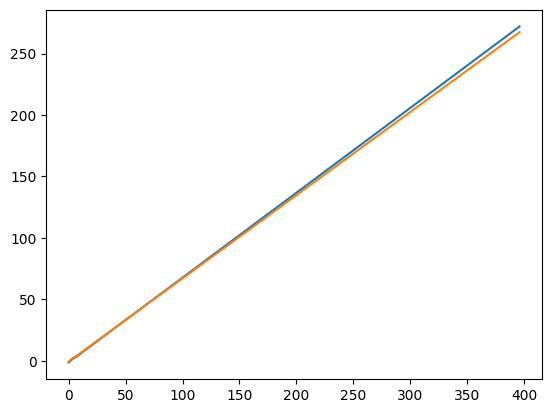

In [117]:
plt.plot([y for y in range(nyg)], [f(current_model.x_val[45],y,"g")for y in range(nyg)])
plt.plot([y for y in range(nyg)], [f(current_model.x_val[100],y,"g")for y in range(nyg)])

In [118]:
@njit
def new_V_v_y_g(y,model):
    """
    
    """
    if model.V !=0:
        M_v = m_u_v( model.u /+ phi* model.e, model.V)/(model.V)
    else:
        M_v = 0
    M_v = m_u_v( model.u /+ phi* model.e, model.V)/(model.V)
    C_u = model.u / (model.u + phi * model.e ) 
    C_e = phi * model.e / (model.u + phi * model.e ) 


    ### matching with employed!:
    potential_unemployed = 0
    int_unemployed = 0
    potential_employed_g = 0
    int_employed_g = 0
    potential_employed_m = 0
    int_employed_m = 0

    for x in range(0, nx):
        if model.V_p_x_y[x,y] > model.V_v_y_g[y] and model.V_e_x_y[x,y] > model.V_u[x] :
            potential_unemployed = potential_unemployed +  model.V_e_x_y[x,y] *model.d_x[x]
            int_unemployed = int_unemployed +  model.d_x[x]
        for y_prime in range(0, nyg):
            if  model.V_p_x_y[x,y] > model.V_v_y_g[y] and model.V_e_x_y[x,y] > model.V_e_x_y[x,y]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,y] *model.d_xy[x,y_prime]
                int_employed_g = int_employed_g + model.d_xy[x,y_prime]
        for y_prime in range(0, nym):
            if  model.V_p_x_y[x,y] > model.V_v_y_g[y] and model.V_e_x_y[x,y] > model.V_e_x_y[x,nyg+y_prime]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,y] *model.d_xy[x,nyg+y_prime]
                int_employed_m = int_employed_m + model.d_xy[x,nyg+y_prime]


    denom = 1/ ( 1 - beta * ( 1 - (1 - delta) * M_v * ( C_u * int_unemployed + C_e * ( lambda_g * int_employed_g + lambda_m * int_employed_m ))))
    num = beta * ( 1 - delta ) * M_v * ( C_u * potential_unemployed + C_e * ( lambda_g * potential_employed_g  + lambda_m * potential_employed_m  ) )
    V = num/denom
    return(V)


In [119]:
@njit
def new_V_v_y_m(y,model):
    """
    
    """
    if model.V !=0:
        M_v = m_u_v( model.u /+ phi* model.e, model.V)/(model.V)
    else:
        M_v = 0
    C_u = model.u / (model.u + phi * model.e ) 
    C_e = phi * model.e / (model.u + phi * model.e ) 


    ### matching with employed!:
    potential_unemployed = 0
    int_unemployed = 0
    potential_employed_g = 0
    int_employed_g = 0
    potential_employed_m = 0
    int_employed_m = 0

    for x in range(0, nx):
        if model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] and model.V_e_x_y[x,nyg+y] > model.V_u[x] :
            potential_unemployed = potential_unemployed +  model.V_e_x_y[x,nyg+y] *model.d_x[x]
            int_unemployed = int_unemployed +  model.d_x[x]
        for y_prime in range(0, nyg):
            if  model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] and model.V_e_x_y[x,nyg+y] > model.V_e_x_y[x,y]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,nyg+y] *model.d_xy[x,y_prime]
                int_employed_g = int_employed_g + model.d_xy[x,y_prime]
        for y_prime in range(0, nym):
            if  model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] and model.V_e_x_y[x,nyg+y] > model.V_e_x_y[x,nyg+y_prime]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,nyg+y] *model.d_xy[x,nyg+y_prime]
                int_employed_m = int_employed_m + model.d_xy[x,nyg+y_prime]


    denom = 1/ ( 1 - beta * ( 1 - (1 - delta) * M_v * ( C_u * int_unemployed + C_e * ( lambda_g * int_employed_g + lambda_m * int_employed_m ))))
    num = beta * ( 1 - delta ) * M_v * ( C_u * potential_unemployed + C_e * ( lambda_g * potential_employed_g  + lambda_m * potential_employed_m  ) )
    V = num/denom
    return(V)


In [120]:
##### new value function for employer
@njit
def new_V_p_x_y(x, y, model, debug = False):
    """
    Update value function for employers at time t
    """
    if y <nyg:
        sector = 'g'
        y_val = model.y_g_val[y]
        V_v =  model.V_v_y_g[y] 
    else:
        sector = 'm'
        y_val = model.y_m_val[y-nyg]
        V_v =  model.V_v_y_m[y-nyg] 
    V_t = model.V_e_x_y[x,y]
    M_e = phi* m_u_v(model.u+ phi* model.e, model.V)/(model.u + phi * model.e)

    int_g = [model.d_y[y_prime]
                                     for y_prime in range(0, nyg) if model.V_e_x_y[x,y_prime] > V_t
                                    and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
    int_m = [ model.d_y[y_prime]
                                     for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] > V_t
                                    and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]

    denom = 1 - beta * (1-delta ) * (1 - M_e * ( 1-  lambda_g * sum(int_g) - lambda_m * sum(int_m) ) )
    flux = f(model.x_val[x],y_val,sector) - w_x_y(x,y,sector, model) + beta * (delta * ( 1+ M_e ) +  (1-delta ) * M_e * ( 1-  lambda_g * sum(int_g) - lambda_m * sum(int_m) ) )  * V_v
    V = (flux )/denom
    if debug == True:
        print((1 - M_e * ( 1-  lambda_g * sum(int_g) - lambda_m * sum(int_m) ) ))
        print(denom)
        print(flux)
        print(sum(int_g))
        print(int_m)
    return(V)


In [221]:
new_V_p_x_y(100,90, current_model, True)

0.846045972158294
0.16911517166278267
1.3303568256018867
0.2702702702702703
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


7.866572895391263

In [174]:
@njit
def movement(model, debug = False):
    """
    Define movement at each period
    """

    new_d_xy = model.d_xy
    ### Variables for debug
    if debug == True:
        lost_matches = 0
        matches_unemp = 0
        matches_emp = 0

    ### First round : jobs exogeneously disappear
    
    for x in range(0,nx):
        for y in range(0, nyg+nym):
            if model.matches[x,y] ==1:
                new_status = np.float64(np.searchsorted(np.cumsum(np.asarray([delta, 1-delta], dtype = np.float64)), np.random.rand(1))[0])
                model.matches[x,y] = new_status
                if new_status == 0:
                    model.d_x[x] = np.float64(1)
                    model.d_y[y] = np.float64(1)
                    if debug == True:
                        lost_matches +=1

    if debug == True:
        print(f'Lost matches: {lost_matches}')

    
    model.d_x = np.asarray([np.ceil(x) for x in model.d_x], dtype = np.float64)
    if np.sum(model.d_x) >0:
        model.d_x = model.d_x/np.sum(model.d_x)
    model.d_y = np.asarray([np.ceil(x) for x in model.d_y], dtype = np.float64)
    if np.sum(model.d_y) > 0:
        model.d_y = model.d_y/np.sum(model.d_y)
    #### Update states
    new_e = np.mean(np.sum(model.matches, axis = 0))
    new_u = 1-new_e
    new_V = 1-np.mean(np.sum(model.matches, axis = 1))
    model.e = new_e
    model.u = new_u
    model.V = new_V
    new_s = phi * new_e + new_u
    #### Update value functions for unmatched agents
    for x in range(0, nx):
        model.V_u[x] = new_V_u_x(x, model)
    for y in range(0,nym):
        model.V_v_y_m[y] = new_V_v_y_m(y, model)
    for y in range(0,nyg):
        model.V_v_y_g[y] = new_V_v_y_g(y, model)

    if debug == True:
        print('Unmatched agent value functions updated')
        print(m_u_v(new_u,new_V))
    ### Second round : matches from unemployment occur

    # random meeting of unmatched agents 
    unmatched_w =   np.asarray([x for x in range(0, nx) if model.d_x[x] >0]  , dtype = np.int64)
    unmatched_f_g = np.asarray([y for y in range(0, nyg) if model.d_y[y] >0], dtype = np.int64)
    unmatched_f_m = np.asarray([y for y in range(nyg, nym+nyg) if model.d_y[y] >0], dtype = np.int64)
    n_unmatched_w = unmatched_w.shape[0]
    n_unmatched_f = unmatched_f_g.shape[0] + unmatched_f_m.shape[0]

    if debug == True:
        print(f'{n_unmatched_w} workers and {n_unmatched_f} firms to match.')
   
    if n_unmatched_w >0 and n_unmatched_f >0:
        for x in unmatched_w:
            matched = 0
            meet = np.searchsorted(np.cumsum(np.asarray([1-m_u_v(new_u,new_V)/new_s,m_u_v(new_u,new_V)/new_s], dtype = np.float64)), np.random.rand(1))[0]
            if meet == 1:
                type_meet = np.int64(np.searchsorted(np.cumsum(np.asarray([lambda_g,lambda_m], dtype =np.float64) ), np.random.rand(1))[0])
                if type_meet == 0: ## meeting unmatched firm from type g
                    try:
                        y = np.random.choice(unmatched_f_g,1)[0]
                        if matched == 0 and model.V_e_x_y[x,y] >= model.V_u[x] and model.V_p_x_y[x,y]>= model.V_v_y_g[y]:
                            model.matches[x,y] = 1
                            matched = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)
                            if debug == True:
                                matches_unemp +=1
                    except:
                        matched = 0
                else:  ## meeting unmatched firm from type m
                    try:
                        y = np.random.choice(unmatched_f_m,1)[0]
                        if matched == 0 and model.V_e_x_y[x,y] >= model.V_u[x] and model.V_p_x_y[x,y]>= model.V_v_y_m[y-nyg]:
                            model.matches[x,y] = 1
                            matched = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)
                            if debug == True:
                                matches_unemp +=1
                    except:
                        matched = 0
    if debug == True:
        print(f'New matches from unemployment: {matches_unemp}')
    new_e = np.mean(np.sum(model.matches, axis = 0))
    new_u = 1-new_e
    new_V = 1-np.mean(np.sum(model.matches, axis = 1))
    model.d_x = np.asarray([np.ceil(x) for x in model.d_x], dtype = np.float64)
    if np.sum(model.d_x) !=0:
        model.d_x = model.d_x/np.sum(model.d_x)
    model.d_y = np.asarray([np.ceil(x) for x in model.d_y], dtype = np.float64)
    if np.sum(model.d_y) !=0:
        model.d_y = model.d_y/np.sum(model.d_y)
    model.e = new_e
    model.u = new_u
    model.V = new_V

    # random meeting of matched agents
    matched_w = np.asarray([x for x in range(0, nx) if model.d_x[x] ==0]  , dtype = np.int64)
    current_match_w =np.argmax(model.matches, axis=1)
    unmatched_f_g = np.asarray([y for y in range(0, nyg) if model.d_y[y] >0], dtype = np.int64)
    unmatched_f_m = np.asarray([y for y in range(nyg, nym+nyg) if model.d_y[y] >0], dtype = np.int64)
    n_matched_w = matched_w.shape[0]
    n_unmatched_f = unmatched_f_g.shape[0] + unmatched_f_m.shape[0]

    if debug == True:
        print(f'{n_matched_w} workers and {n_unmatched_f} firms to potentially match.')
    if n_matched_w >0 and n_unmatched_f >0:
        for x in matched_w:
            rematch = 0
            meet = np.searchsorted(np.cumsum(np.asarray([1- phi * m_u_v(new_u,new_V)/new_s, phi * m_u_v(new_u,new_V)/new_s], dtype = np.float64)), np.random.rand(1))[0]
            if meet == 1:
                type_meet = np.int64(np.searchsorted(np.cumsum(np.asarray([lambda_g,lambda_m], dtype =np.float64) ), np.random.rand(1))[0])
                if type_meet == 0:
                    try:
                        y = np.random.choice(unmatched_f_g,1)[0]
                        if rematch == 0 and model.d_y[y] != 0 and model.V_e_x_y[x,current_match_w[x]] <= model.V_e_x_y[x,y] and model.V_p_x_y[x,y] >= model.V_v_y_g[y]:
                            model.matches[x,y] = 1
                            model.matches[x,current_match_w[x]] = 0
                            rematch = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)
                            model.d_y[current_match_w[x]] = np.float64(1)
                            if debug == True:
                                matches_emp +=1
                    except:
                        rematch = 0
        
                else:
                    try:
                        y = np.random.choice(unmatched_f_m,1)[0]
                        if rematch == 0 and model.d_y[y] != 0 and model.V_e_x_y[x,current_match_w[x]] <= model.V_e_x_y[x,y] and model.V_p_x_y[x,y] >= model.V_v_y_m[y-nyg]:
                            model.matches[x,y] = 1
                            model.matches[x,current_match_w[x]] = 0
                            rematch = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)
                            model.d_y[current_match_w[x]] = np.float64(1)
                            if debug == True:
                                matches_emp +=1
                    except:
                        rematch = 0

    if debug == True:
        print(f'New matches from employment: {matches_emp}')

    model.d_x = np.asarray([np.ceil(x) for x in model.d_x], dtype = np.float64)
    if np.sum(model.d_x) !=0:
        model.d_x = model.d_x/np.sum(model.d_x)
    model.d_y = np.asarray([np.ceil(x) for x in model.d_y], dtype = np.float64)
    if np.sum(model.d_y) !=0:
        model.d_y = model.d_y/np.sum(model.d_y)

    model.d_xy = model.matches/np.sum(model.matches)

    model.e = np.mean(np.sum(model.matches, axis = 0))
    model.u = 1-new_e
    model.V = 1-np.mean(np.sum(model.matches, axis = 1))


    ### Recompute value functions for matched agents
    for x in range(0,nx):
        for y in range(0, nyg+nym):
            model.V_e_x_y[x,y] = new_V_e_x_y(x,y,model)
            model.V_p_x_y[x,y] = new_V_p_x_y(x,y,model)
    

    return('ok')
    

In [175]:
#reinitialise

current_model = ModelCurrent(x_distrib,y_distrib_g,y_distrib_m)

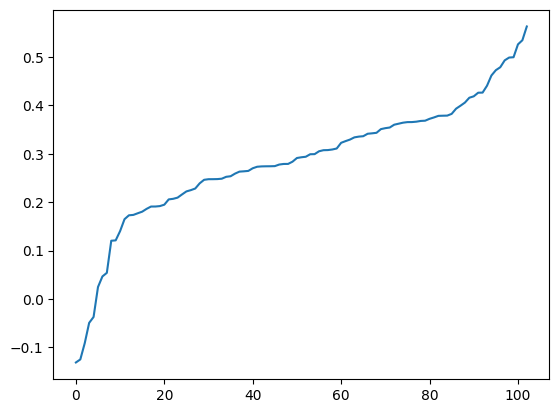

In [176]:
#plt.plot([y for y in range(0, nym)], [f(current_model.x_val[50],current_model.y_m_val[y],'m') for y in range(0, nym)])
plt.plot([y for y in range(0, nym)], [w_x_y(50,y,'m', current_model) for y in range(nyg, nyg+nym)])

In [177]:
w_x_y(50,0,'m', current_model) 

-0.18614036430366906

In [178]:
movement(current_model, True)

Lost matches: 2
Unmatched agent value functions updated
0.017719949980705883
2 workers and 2 firms to match.
New matches from unemployment: 0
591 workers and 2 firms to potentially match.
New matches from employment: 1


'ok'

In [198]:
all_seq = []
for i in range(100):
    movement(current_model, True)
    current_V_u_x = np.copy(current_model.V_u)
    current_V_e_x_y = np.copy(current_model.V_e_x_y)
    current_V_p_x_y = np.copy(current_model.V_p_x_y)
    current_V_v_y_g = np.copy(current_model.V_v_y_g)
    current_V_v_y_m = np.copy(current_model.V_v_y_m)
    current_matches = np.copy(current_model.matches)
    
    current_e = np.copy(current_model.e)
    current_V = np.copy(current_model.V)
    current_u = np.copy(current_model.u)
    row_seq ={ 'e' : current_e
              ,'V' : current_V
              ,'u' : current_u
              ,'V_u' : current_V_u_x
              ,'V_e_x_y' : current_V_e_x_y
              ,'V_p_x_y' : current_V_p_x_y
              ,'V_v_y_g' : current_V_v_y_g
              ,'V_v_y_m' : current_V_v_y_m
              ,'matches' : current_matches
              }
    all_seq.append(row_seq)

Lost matches: 4
Unmatched agent value functions updated
0.03894996141330321
62 workers and 24 firms to match.
New matches from unemployment: 7
538 workers and 18 firms to potentially match.
New matches from employment: 3
Lost matches: 7
Unmatched agent value functions updated
0.03654192076257829
62 workers and 24 firms to match.
New matches from unemployment: 4
535 workers and 21 firms to potentially match.
New matches from employment: 4
Lost matches: 5
Unmatched agent value functions updated
0.03654192076257829
63 workers and 25 firms to match.
New matches from unemployment: 5
535 workers and 20 firms to potentially match.
New matches from employment: 2
Lost matches: 6
Unmatched agent value functions updated
0.03894996141330321
64 workers and 26 firms to match.
New matches from unemployment: 2
531 workers and 24 firms to potentially match.
New matches from employment: 7
Lost matches: 4
Unmatched agent value functions updated
0.03894996141330321
66 workers and 26 firms to match.
New ma

In [199]:
V_v_y_m_simul = [row['V_v_y_m'] for row in all_seq]

In [200]:
[np.mean(V_v_y_m) for V_v_y_m in V_v_y_m_simul].index(0)

40

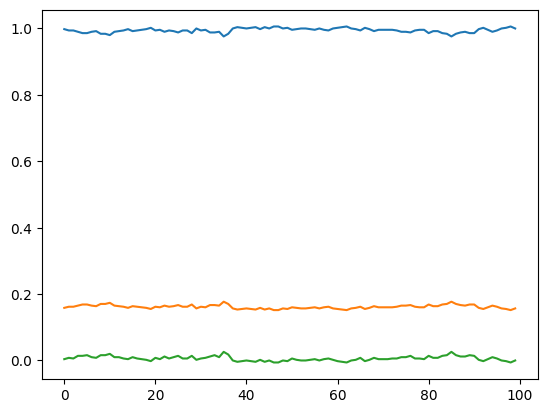

In [201]:
plt.plot([i for i in range(len(all_seq))], [all_seq[i]['e'] for i in range(len(all_seq))])
plt.plot([i for i in range(len(all_seq))], [all_seq[i]['V'] for i in range(len(all_seq))])
plt.plot([i for i in range(len(all_seq))], [all_seq[i]['u'] for i in range(len(all_seq))])

In [183]:
x_indices = np.asarray([int(np.where(current_model.matches[x] ==1)[0]) if len(np.where(current_model.matches[x] ==1)[0])==1 else -1 
                        for x in range(0, nx)] )
realised_matches_g = [ [x, x_indices[x]] for x in range(0,nx) if x_indices[x] !=-1 and x_indices[x] < nyg ]
np.corrcoef([x[0] for x in realised_matches_g],[x[1] for x in realised_matches_g])

C:\Users\raphael.wargon\AppData\Local\Temp\ipykernel_20404\3680129238.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_indices = np.asarray([int(np.where(current_model.matches[x] ==1)[0]) if len(np.where(current_model.matches[x] ==1)[0])==1 else -1


array([[ 1.        , -0.24618967],
       [-0.24618967,  1.        ]])

In [184]:
realised_matches_m = [ [x, x_indices[x]] for x in range(0,nx) if x_indices[x] !=-1 and x_indices[x] > nyg ]
np.corrcoef([x[0] for x in realised_matches_m],[x[1] for x in realised_matches_m])

array([[ 1.        , -0.12257045],
       [-0.12257045,  1.        ]])

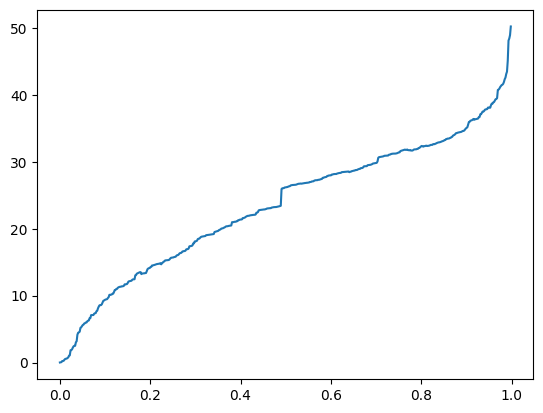

In [185]:
#plt.plot([i for i in range(nx)], [np.mean(V_u_x, axis = 0)[i] for i in range(nx)])
plt.plot([i/nx for i in range(nx)], [
    np.mean([all_seq[j]['V_u'][i] for j in range(len(all_seq))], axis = 0)for i in range(nx)])

In [207]:
x_indices, y_indices = np.where(np.asarray([x[nyg:nyg+nym] for x in current_model.matches] )== 1)
np.corrcoef(x_indices, y_indices)

array([[ 1.        , -0.05648863],
       [-0.05648863,  1.        ]])

In [208]:
np.asarray([x[nyg:nyg+nym] for x in current_model.matches] )

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [209]:
np.mean([all_seq[i]['e'] for i in range(0,len(all_seq))])* delta 

0.009945

In [210]:
(1 - delta ) * np.mean([all_seq[i]['u'] for i in range(0,len(all_seq))]) * m_u_v(np.mean([all_seq[i]['u'] for i in range(0,len(all_seq))]),
                                                                                     np.mean([all_seq[i]['V']for i in range(0,len(all_seq))]))

0.000131366374877891

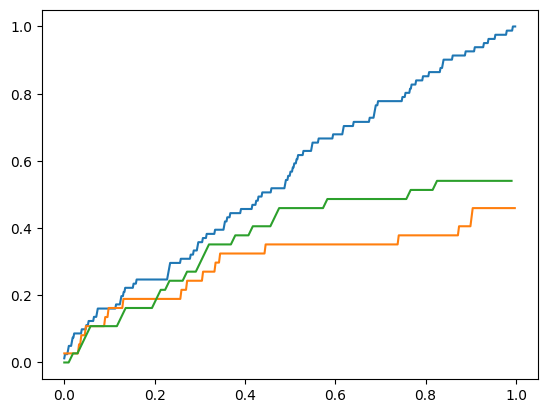

In [211]:
plt.plot([i/len(current_model.d_x) for i in range(len(current_model.d_x))], np.cumsum([current_model.d_x[i] for i in range(len(current_model.d_x))]))
plt.plot([i/nyg for i in range(nyg)], np.cumsum([current_model.d_y[i] for i in range(nyg)]))
plt.plot([i/(nym) for i in range(0,nym)], np.cumsum([current_model.d_y[i] for i in range(nyg,nyg+nym)]))


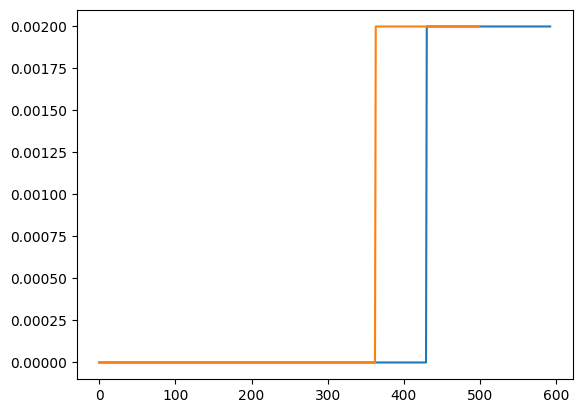

In [212]:
plt.plot([i for i in range(len(current_model.d_x))], np.cumsum([current_model.d_xy[i,90] for i in range(len(current_model.d_x))]))
plt.plot([i for i in range(len(current_model.d_y))], np.cumsum([current_model.d_xy[90,i] for i in range(len(current_model.d_y))]))


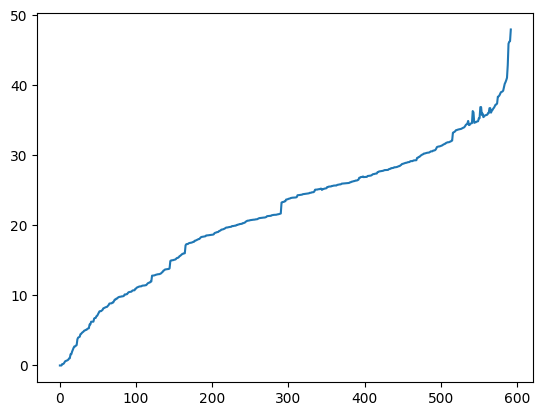

In [213]:
plt.plot([x for x in  range(0,nx)], [current_model.V_u[x] for x in range(0, nx)])

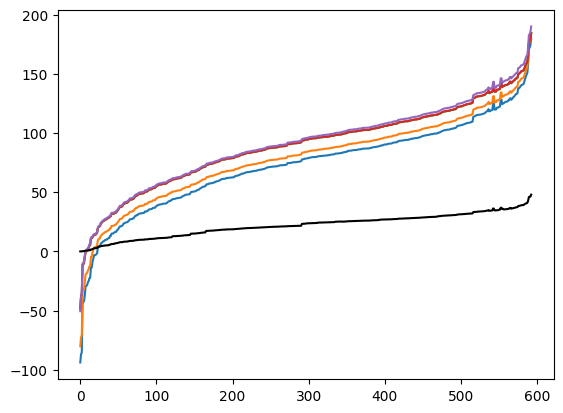

In [215]:
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,0] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,19] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,59] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,60] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,99] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_u[x] for x in range(0, nx)], color= 'black')

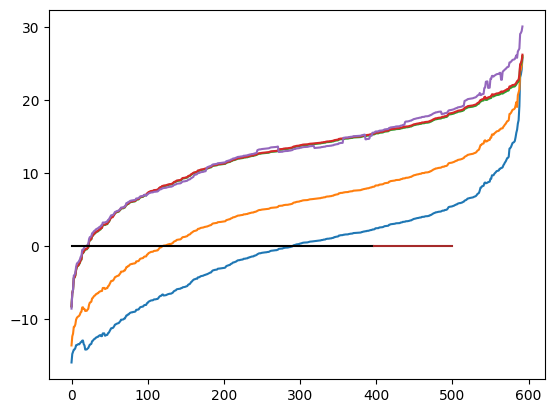

In [216]:
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,0] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,19] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,59] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,60] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,99] for x in range(0, nx)])
plt.plot([x for x in  range(0,nyg)], [current_model.V_v_y_g[x] for x in range(0, nyg)], color = 'black')
plt.plot([x for x in  range(nyg,nyg+nym)], [current_model.V_v_y_m[x] for x in range(0, nym)], color = 'brown')


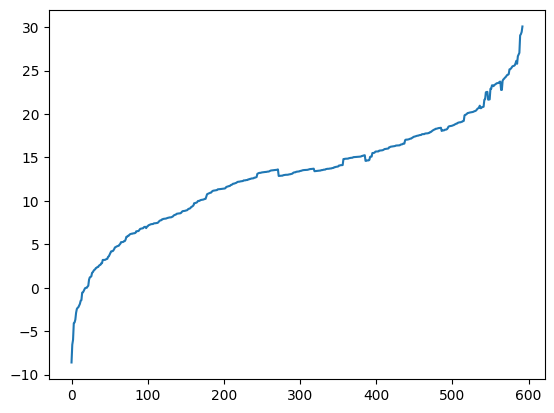

In [217]:
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,99] for x in range(0, nx)])


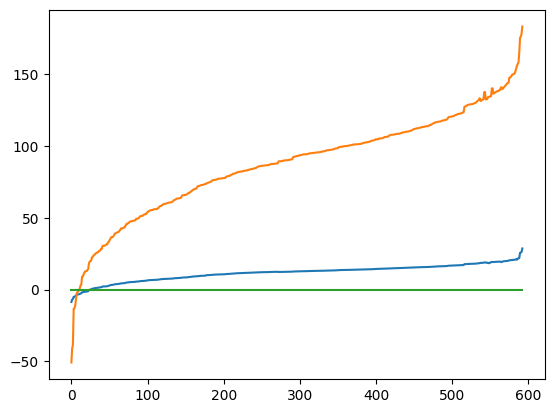

In [218]:
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,50] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,50] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_v_y_g[50] for x in range(0, nx)])


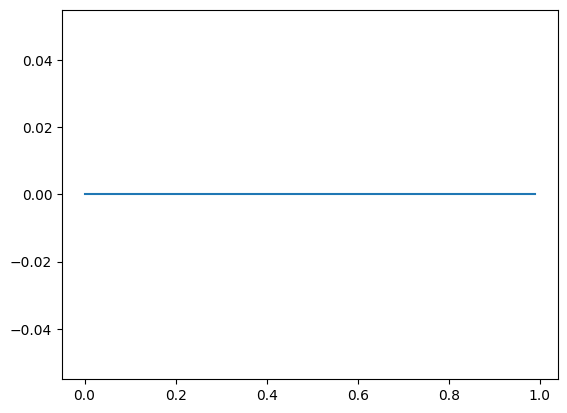

In [220]:
plt.plot([x/nyg for x in  range(0,nyg)], [current_model.V_v_y_g[x] for x in range(0, nyg)])
plt.plot([x/nym for x in  range(0,nym)], [current_model.V_v_y_m[x] for x in range(0, nym)])
